<h1>Lab 1: Basic Digital Signal Processing</h1>

# Initialization

In [1]:
import numpy as np
from scipy import ndimage
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

# Exercise 1. *Implement the function **iradon**. The program should takes as an input a matrix with columns corresponding to the Radon transform along the angles given in the vector that you pass a second parameter. The outpout of the program should be a ‘matrix that correspond to an approximation to the original image.*

In python the Radon transform is not implemented, at least not in the most used libraries. (some public repos can be found that offer a function for it) </br>
For this reason, we start by implementing a function to compute the Radon transform. </br>
We have 

$$\theta_s := \left\{ x \in \mathbb{R}^2: \; x\cdot \theta = s \right\}, \;\;\; f: \mathbb{R}^2\rightarrow \mathbb{R}$$

$$\mathcal{R}f(\theta, s) = \mathcal{R}_{\theta}f(s) = \int_{\theta_s}f(x)dx$$

We can handle the image transformations pretty easily using the skimage.transform library

In [2]:
def Radon_transform(IMG, theta=np.arange(180)):
    # Pad the image with zeros so we don't lose anything when we rotate.
    iLength, iWidth = IMG.shape
    iDiag = np.sqrt(iLength**2 + iWidth**2)
    LengthPad = np.ceil(iDiag - iLength).astype(int) + 2
    WidthPad = np.ceil(iDiag - iWidth).astype(int) + 2
    padIMG = np.zeros((iLength+LengthPad, iWidth+WidthPad))
    padIMG[LengthPad//2:(LengthPad//2+iLength), 
           WidthPad//2:(WidthPad//2+iWidth)] = IMG
    
    # Loop over the number of angles, rotate 90-theta (because we can easily sum
    # if we look at stuff from the top), and then add up.
    n = len(theta)
    PR = np.zeros((padIMG.shape[1], n))
    for i in range(n):
        tmpimg = ndimage.rotate(padIMG, 90-theta[i], reshape=False, order=0)
        PR[:, i] = np.sum(tmpimg, axis=0)
    return PR

To test this on an image, we can generate a phantom image. In order to remain aligned to the lab we will use a phantom image, even though the function generating it is not easily retrievable. Few of the libraries handling it have been deprecated, but the following shepp_logan_phantom() function from the skimage.data library works corretly. The only issue is that it does not allow for a parameter to specifiy the resolution of the image to be generated, and the default resolution is a bit large. Therefore, we handle the lowering of the resolution manually using the skimage.transform library

Generated phantom image


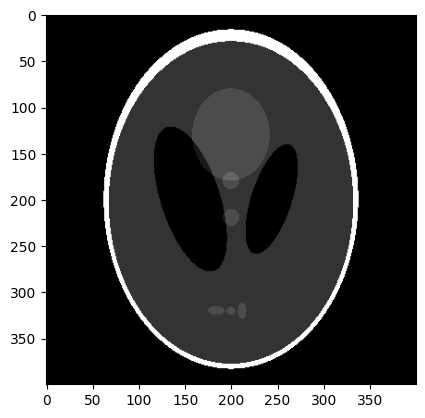

Resized phantom image: (256, 256)


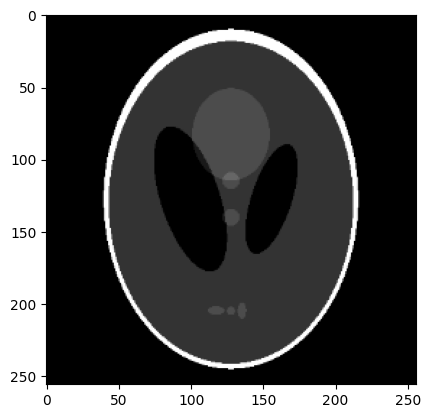

In [3]:
# Generate the phantom image
generated_phantom_image = shepp_logan_phantom()

# Resize the image to a resolution of 256 x 256 pixels
N = 256
shape=(N, N)
phantom_image = resize(generated_phantom_image, shape, anti_aliasing=True)

# Display the image
print("Generated phantom image")
plt.imshow(generated_phantom_image, cmap='gray')
plt.show()

# Display the image
print("Resized phantom image:", shape)
plt.imshow(phantom_image, cmap='gray')
plt.show()

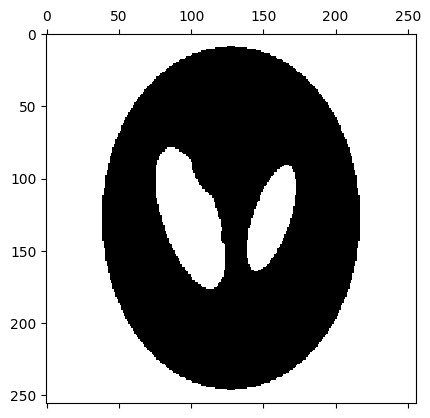

In [4]:
plt.spy(phantom_image)

We then apply the Radon transform on a range of $\theta=[0,1,\ldots,179]$

In [5]:
theta = np.arange(180)
PHANTOM = Radon_transform(phantom_image, theta=theta)
PHANTOM

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Depending on $N$ and the type of image the obtained matrix can be a bit sparse, so we can use a greymap representation as well as the spy() function to visualize it better

Radon transform:


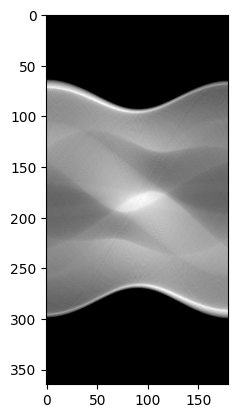

In [6]:
# Display the Radon transform
print("Radon transform:")
plt.imshow(PHANTOM, cmap='gray')
plt.show()

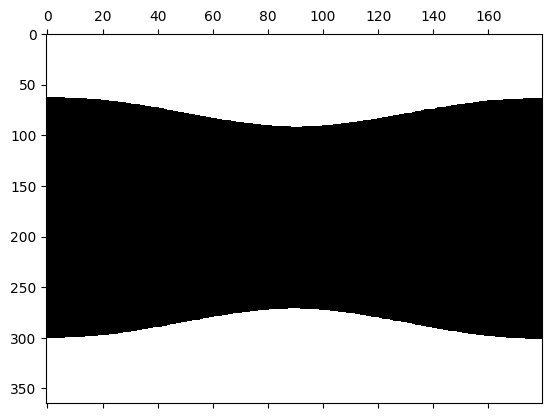

In [7]:
plt.spy(PHANTOM, aspect='auto')

We now focus on implementing an inverse transformation to reconstruct the original image from the projections we obtain with the Radon transform. In order to do so we implement the solution in two steps, the filtereing of the projections and the backprojection. The filtering part is vary case sensitive, and there is no optimal filter for every case, so we will begin by implementing the backprojection part of our inverse Radon transform function

In [8]:
def backprojection(radon_transform, angles, output_size):
    num_angles = len(angles)
    reconstructed_image = np.zeros(output_size)
    center = np.array(output_size) // 2

    for i in range(num_angles):
        angle = angles[i]*np.pi/180
        sinogram_row = radon_transform[:,i]
        for j in range(output_size[0]):
            for k in range(output_size[1]):
                x = j - center[0]
                y = k - center[1]
                projection = x * np.cos(angle) + y * np.sin(angle)
                projection_index = int(projection + 0.5) + center[0]
                if 0 <= projection_index < len(sinogram_row):
                    reconstructed_image[j, k] += sinogram_row[projection_index]

    if output_size[0]==output_size[1]:   # if the image is a square (in this case the padding can be easily removed dividing by sqrt(2))
        n_pixels = int(output_size[0]/np.sqrt(2))
        resized_image = np.zeros([n_pixels, n_pixels])
        resized_image = reconstructed_image[(output_size[0]-n_pixels)//2:(output_size[0]-n_pixels)//2+n_pixels, (output_size[0]-n_pixels)//2:(output_size[0]-n_pixels)//2+n_pixels]

        return resized_image

    return reconstructed_image

We can now observe how this backprojection step by itself reconstructs the image

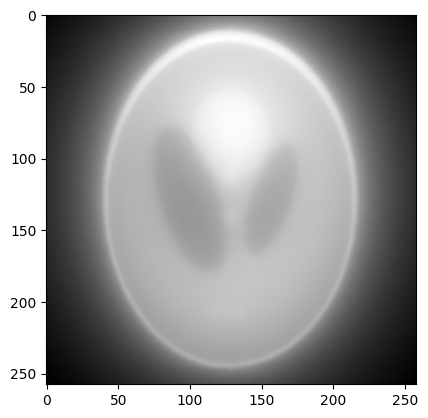

In [9]:
# Backprojection
backprojected_image = backprojection(PHANTOM, theta, [PHANTOM.shape[0], PHANTOM.shape[0]])

# Display the backprojected image
plt.imshow(backprojected_image, cmap='gray')
plt.show()

As we can see, the result is close enough to resemble  what we would like to have. 
However, we can try to improve it by implementing the filtering step in order to see if it allows for a more accurate reconstruction of the image. We do so defining the iradon function, which will put together the two steps, receiving the Radon transform projection image, and returning the reconstructed image. Here we define some auxiliary functions to define some simple filters

In [10]:
def simple_lowpass_filter(array_length, frequency_cutoff):
  filter = np.zeros(array_length)
  freq = np.linspace(0, 2*np.pi, array_length)
  for i in range(array_length):
      if freq[i]<=frequency_cutoff:
        filter[i]=1

  return filter

In [20]:
def simple_bandwidth_filter(array_length, frequency_cutoff):
  low_cut = frequency_cutoff[0]
  high_cut = frequency_cutoff[1]
  filter = np.zeros(array_length)
  freq = np.linspace(0, 2*np.pi, array_length)
  for i in range(array_length):
      if ((freq[i]>=low_cut) and (freq[i]<=high_cut)):
        filter[i]=1

  return filter

In [12]:
def ram_lak_filter(array_length, frequency_cutoff):
    """
    Computes the Ram-Lak filter for a 1D array in the Fourier space.

    Args:
        array_length (int): The length of the 1D array.
        frequency_cutoff (float): The cutoff frequency for the filter.

    Returns:
        numpy.ndarray: The Ram-Lak filter for the 1D array in the Fourier space.

    """
    filter = np.zeros(array_length)

    center = int(array_length / 2)

    for i in range(array_length):
        distance = abs(i - center)
        if distance == 0:
            filter[i] = 1
        else:
            filter[i] = np.abs(np.sin(np.pi * distance / frequency_cutoff) / (np.pi * distance / frequency_cutoff))

    return filter

In [32]:
def ram_lak_filter(array_length, frequency_cutoff):
    """
    Computes the Ram-Lak filter for a 1D array in the Fourier space.

    Args:
        array_length (int): The length of the 1D array.
        frequency_cutoff (float): The cutoff frequency for the filter.

    Returns:
        numpy.ndarray: The Ram-Lak filter for the 1D array in the Fourier space.

    """
    filter = np.zeros(array_length)

    center = int(array_length / 2)

    for i in range(array_length):
        distance = abs(i - center)
        if distance == 0:
            filter[i] = 1
        else:
            filter[i] = np.abs(np.sin(np.pi * distance / frequency_cutoff) / (np.pi * distance / frequency_cutoff))

    return filter

It is worth noting that the optimal filters strongly depend on the problem we are trying to solve. This is both due to possible different kinds of noises in the images and projections, as well as the requirements of what we're interested in. (concrete applications of the Radon transform might require for the accurate reconstruction of parts of the image with different features and characteristics)

In [25]:
def iradon(pr, freq_cutoff, theta=np.arange(180), filter_type='ramp', mode='fft'):
    """Perform inverse Radon transform (backprojection) on projections 'pr' given in
    sinogram (i.e., "projection") format using the filtered backprojection method.

    Parameters
    ----------
    pr : ndarray
        Sinogram of the image to be reconstructed, in projection (sinogram) format. The
        sinogram is a 2D array where each row corresponds to a projection taken at a
        specific angle. The number of rows should correspond to the number of angles
        provided in 'theta'. The number of columns should be odd.
    theta : ndarray or sequence, optional
        Sequence of projection angles in degrees. If 'None' (default), the angles are
        assumed to be equally spaced over the interval [0, 180).
    filter_type : {'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', 'none'}, optional
        Type of filter to use for backprojection. Default is 'ramp'.

    Returns
    -------
    im : ndarray
        Reconstructed image. The shape of the image will be (n x n), where 'n' is the
        number of columns in the sinogram. The pixel spacing will be assumed to be 1
        pixel per unit distance.

    Raises
    ------
    ValueError
        If the filter specified is not implemented

    """
    # Ensure that the sinogram has an odd number of columns
    #if pr.shape[0] % 2 == 0:
    #    raise ValueError('Sinogram must have an odd number of columns')

    # This can be used to visualize the projection 
    #print("Original projection:")
    #plt.imshow(pr, cmap='gray')
    #plt.show()

    # Determine the number of angles
    n_angles = pr.shape[1]

    # Determine the size of the reconstruction
    n_pixels = pr.shape[0]
    n_rows = n_pixels
    n_cols = n_pixels

    # Filtering of the projection image using a convolution --------------------
    if mode=='conv':
        # Initialize the convolution filter
        if filter_type == 'ram-lak':
            filter_func = ram_lak_filter
        else:
            raise ValueError('Invalid filter type')

        # Apply the filter to the projections
        filtered_pr = np.zeros_like(pr)
        for i in range(n_angles):
            projection = pr[:, i]
            filtered_projection = np.convolve(filter_func(np.linspace(0, 2*np.pi, n_pixels)), projection, mode='same')   # This is not optimal
            filtered_pr[:, i] = filtered_projection    

    # Filtering of the projection image in the Fourier transform space ---------
    if mode=='fft':
        # Initialize the fft filter
        if filter_type == 'simple_lowpass':
            filter_func = simple_lowpass_filter
        elif filter_type == 'simple_bandwidth':
            filter_func = simple_bandwidth_filter
        else:
            raise ValueError('Invalid filter type')

        # Apply the filter to the projections
        filtered_pr = np.zeros_like(pr)
        for i in range(n_angles):
            projection = pr[:, i]
            projection = np.fft.fft(projection)
            filtered_projection = np.fft.ifft(projection * filter_func(n_pixels, freq_cutoff)).real
            filtered_pr[:, i] = filtered_projection    
                                                                             

    # This can be used to visualize the filtered projection 
    #print("Filtered projection:")
    #plt.imshow(filtered_pr, cmap='gray')
    #plt.show()

    # Attempt 1: Backprojection ------------------------------------------------
    # Initialize the reconstruction array
    #reconstruction = np.zeros((n_rows, n_cols))

    # Perform backprojection
    #mid_col = n_cols // 2
    #x_vals = np.arange(-mid_col, mid_col + n_cols % 2)
    #for i, angle in enumerate(theta):
    #    projection = filtered_pr[:,i]
    #    angle_radians = np.deg2rad(angle)
    #    row_coords = x_vals * np.sin(angle_radians)
    #    col_coords = x_vals * np.cos(angle_radians)
    #    row_idxs = np.round(row_coords + n_rows // 2).astype(int)
    #    col_idxs = np.round(col_coords + n_cols // 2).astype(int)
    #    valid_idxs = np.logical_and(row_idxs >= 0, row_idxs < n_rows)
    #    valid_idxs = np.logical_and(valid_idxs, col_idxs >= 0)
    #    valid_idxs = np.logical_and(valid_idxs, col_idxs < n_cols)
    #    reconstruction[row_idxs[valid_idxs], col_idxs[valid_idxs]] += projection[valid_idxs]

    # Attempt 2: Backprojection ------------------------------------------------
    reconstruction = backprojection(filtered_pr, theta, [n_rows, n_cols])

    return reconstruction / n_angles

Using this iradon function to reconstruct the image produces the following. It is possible to experiment a bit using the different filters. Here is presented one result that is making use of a simple bandwith filter applied in the fft space and hand-tuned a bit. (We consider this result to be satisfying thinking about applications such as brainscans, where we aim at a higher contrast to identify patches, thus also requiring some low-freq denoising)

Reconstructed phantom image: (256, 256)


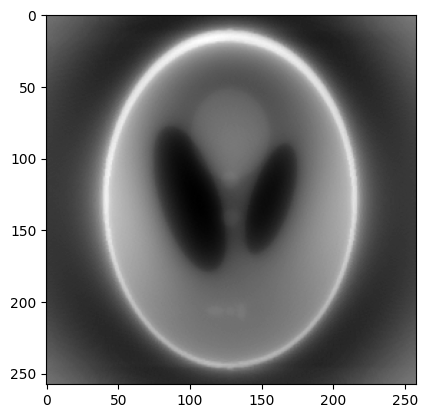

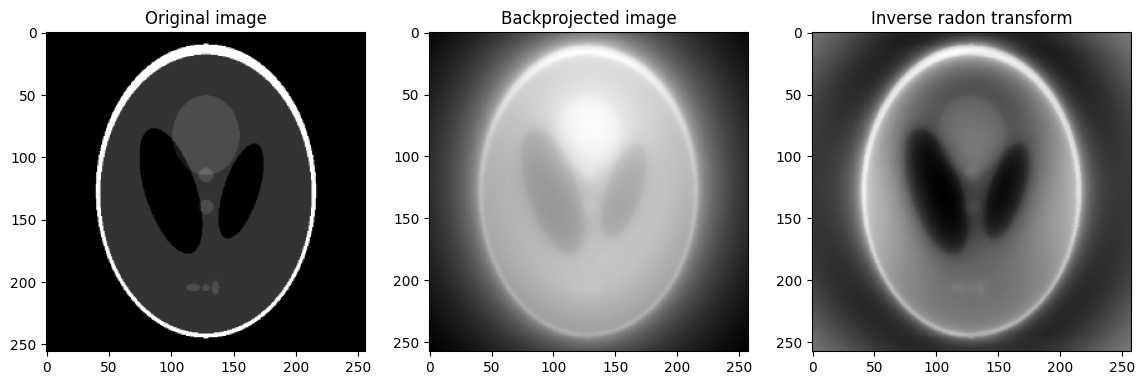

In [ ]:
freq_cutoff = [0.04, np.pi*1.5]
reconstructed_image = iradon(PHANTOM, freq_cutoff=freq_cutoff, theta=theta, filter_type='simple_bandwidth', mode='fft')

# Display the reconstructed image
print("Reconstructed phantom image:", shape)
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

# Compare the images
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.title.set_text('Original image')
ax1.imshow(phantom_image, cmap='gray')
ax2.title.set_text('Backprojected image')
ax2.imshow(backprojected_image, cmap='gray')
ax3.title.set_text('Inverse radon transform')
ax3.imshow(reconstructed_image, cmap='gray')
plt.show()

As we can see, implementing the filtering of the projection image allows for a considerably better reconstruction of the image. We still have a loss of sharpness and contrast of the image, which should be expected. The result could be improved testing other types of filters or using a more dense range of angles from which we compute the projections, during the Radon transform. </br>
**Note:** It should be noted that the computational time is a bit demanding, and it scales quickly with the size of the images, meaning the resolution of the original image and the number of angles used for sampling. In this case we used a 256x256 image with a set of 180 angles, as requested in the lab. The computational time in this case is still acceptable, being of only few minutes, but increasing the dimensions of the problem would make the implemented functions not optimal to solve it. (Some effort would have to be spent in optimizing them)